In [1]:
import numpy as np
import pandas as pd
from imageio import imread
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns
import os
import cv2
from models import *
from common import createTerrainData, create_X, standard_scaling_single, remove_intercept, load_model, create_img_patches
from cmcrameri import cm


print(f"Root directory: {os.getcwd()}")
# plt.rcParams.update({
#     "text.usetex": True,
#     "font.family": "serif",
#     "font.serif": ["Palatino"],
#     "font.size": 10,
# })

#%matplotlib

Root directory: /home/arefrode/uio/fys-stk4155/projects/FYS-STK4155-Prj2_report/code


# Reading data and resizing

In [ ]:
# Load the terrain
terrain1_file = "SRTM_data_Norway_1.tif"
terrain2_file = "SRTM_data_Norway_2.tif"
terrain1 =  imread(f'{INPUT_DATA}{terrain1_file}')
terrain2 = imread(f'{INPUT_DATA}{terrain2_file}')

# Resizing the image
rescale_factor = 0.1
y_size = int(terrain1.shape[0] * rescale_factor)
x_size = int(terrain1.shape[1] * rescale_factor)
terrain1Resized = cv2.resize(terrain1, (x_size, y_size))
terrain2Resized = cv2.resize(terrain2, (x_size, y_size))

# Plotting terrain
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.title.set_text("Terrain over Norway 1 (Resized)")
ax1.set_xlabel("X"); ax1.set_ylabel("Y")
surf1 = ax1.imshow(terrain1Resized, cmap='gray')
ax2.title.set_text("Terrain over Norway 2 (Resized)")
ax2.set_xlabel("X"); ax2.set_ylabel("Y")
surf2 = ax2.imshow(terrain2Resized, cmap='gray')
plt.show()

# Creating image patches and Terrain data selection

In [ ]:
nXpatches = 3; nYpatches=6
y_steps = int(terrain2Resized.shape[0] / nYpatches); print(y_steps)
x_steps = int(terrain2Resized.shape[1] / nXpatches); print(x_steps)
patches_1 = create_img_patches(terrain1Resized, y_steps, x_steps)
#fig1 = plotTerrainPatches(patches_1, nYpatches, nXpatches, plotTitle="Terrain1 patches")
#plt.show()
patches_2 = create_img_patches(terrain2Resized, y_steps, x_steps)
#fig2 = plotTerrainPatches(patches_2, nYpatches, nXpatches, plotTitle="Terrain2 patches")
#plt.show()

# Choosing two interesting terrain patches
img1 = patches_1[2]
img2 = patches_2[5]
x1, y1, z1 = createTerrainData(img1)
x2, y2, z2 = createTerrainData(img2)

# Constructing the terrain data
terrain_data = 1
if terrain_data == 1: # Choosing terrain1*
    x, y, z = x1, y1, z1.copy() 
    #z_min = np.min(z)
    z_max = np.max(z)
    z = z1

elif terrain_data == 2: # Choosing terrain2
    x, y, z = x2, y2, z2.copy() 
    #z_min = np.min(z)
    z_max = np.max(z)
    z = z2
    
z_flat = z.ravel(); z_flat = z_flat.reshape(-1,1)

In [ ]:
deg = 10
X = create_X(x, y, deg) # Design Matrix 
X = remove_intercept(X)
print("Number of features:", X.shape[1])
X_scaled, _ = standard_scaling_single(X)
z_scaled, z_scaler = standard_scaling_single(z.ravel().reshape(-1,1))
        
# Using fitted model to predict the terrain patch 
path_OLS = "../data/models/best_OLS_model_degree_10_MSE_0.16814632605067817.pkl"
best_OLS_model = load_model(path_OLS)

z_hat_OLS = best_OLS_model.predict(X_scaled).reshape(60,60)
#z_hat_OLS = z_scaler.inverse_transform(z_hat_OLS.reshape(-1,1))
#z_hat_OLS = z_hat_OLS.reshape((60,60))
MSE_OLS = MSE(z_scaled, z_hat_OLS.flatten())
print(z_hat_OLS.shape)
print("OLS_MSE:", MSE_OLS)

# Best NN vs OLS

In [ ]:
deg = 1
X = create_X(x, y, deg) # Design Matrix 
X = remove_intercept(X)
X_scaled, _ = standard_scaling_single(X)
z_scaled, z_scaler = standard_scaling_single(z.ravel().reshape(-1,1))
path= "../data/models/the_very_best_model/"
filename = f"{path}best_large_model_leaky_relu_mse_0.108.pkl"
best_NN_model = load_model(filename)
z_hat_NN = best_NN_model.predict(X_scaled.copy()).reshape(60,60)
# z_hat = z_scaler.inverse_transform(z_hat.reshape(-1,1))
# z_hat = z_hat.reshape((y_steps,x_steps))
# mean_val = np.round(np.mean(z_hat),decimals=1)
# var_val = np.round(np.var(z_hat),decimals=1)
MSE_NN = MSE(z_scaled, z_hat_NN.flatten())
print(z_hat_NN.shape)
print("NN_MSE:", MSE_NN)

In [ ]:
colormap = cm.vik

# 2D plots
plt.figure()
fig, axes = plt.subplots(1, 3, sharex=True, sharey=True, figsize=(7,2))
axes[0].imshow(z, cmap=colormap )
axes[0].set_xlabel("Target terrain")
axes[0].set_xticks([])
axes[0].set_yticks([])
axes[1].imshow(z_hat_NN, cmap=colormap )
axes[1].set_xlabel(f"NN prediction\nMSE: {np.around(MSE_NN, decimals=4)}")
axes[2].imshow(z_hat_OLS, cmap=colormap )
axes[2].set_xlabel(f"OLS prediction\nMSE: {np.around(MSE_OLS, decimals=4)}")
plt.suptitle("Comparing NN with OLS predictions")
plt.savefig("../figures/NN_vs_OLS_2D.pdf", bbox_inches='tight')
plt.show()


# 3D plots
fig = plt.figure(figsize=(8,12))
ax = fig.add_subplot(3,3,1, projection='3d')
title = f"Target terrain in 3D "
ax.title.set_text(title)
#ax.set_xlabel("x"); ax.set_ylabel("y"); ax.set_zlabel("z")
ax.view_init(elev=-75., azim=-91)
ax.plot_surface(x, y, z, cmap=colormap, linewidth = 0, antialiased=False)

ax = fig.add_subplot(3,3,2, projection='3d')
title = f"NN prediction in 3D\nMSE: {np.around(MSE_NN, decimals=4)}"
ax.title.set_text(title)
# ax.set_xlabel("x"); ax.set_ylabel("y"); ax.set_zlabel("z")
ax.view_init(elev=-75., azim=-91)
ax.plot_surface(x, y, z_hat_NN, cmap=colormap, linewidth = 0, antialiased=False)

ax = fig.add_subplot(3,3,3, projection='3d')
title = f"OLS prediction in 3D\nMSE: {np.around(MSE_OLS, decimals=4)}"
ax.title.set_text(title)
# ax.set_xlabel("x"); ax.set_ylabel("y"); ax.set_zlabel("z")
ax.view_init(elev=-75., azim=-91)
ax.plot_surface(x, y, z_hat_OLS, cmap=colormap, linewidth = 0, antialiased=False)

plt.suptitle("Comparing NN with OLS predictions in 3D")
plt.tight_layout()
plt.savefig("../figures/NN_vs_OLS_3D.pdf", bbox_inches='tight')
plt.show()

# Parameters VS MSE - Sigmoid function

In [ ]:
sigmoid_file = f"{REPORT_DATA}PARAMETERS_sigmoid_results.csv"
sigmoid_results = pd.read_csv(sigmoid_file)

relu_file = f"{REPORT_DATA}PARAMETERS_relu_results.csv"
relu_results = pd.read_csv(relu_file)

leaky_relu_file = f"{REPORT_DATA}PARAMETERS_leaky_relu_results.csv"
leaky_relu_results = pd.read_csv(leaky_relu_file)

# Plot
fig, [ax1, ax2, ax3] = plt.subplots(3, figsize=(5,7))
plt.suptitle("Grid search - own NN\nMSE relative to the number of parameters")
sns.pointplot(data=sigmoid_results, x="parameters_own_NN", y="MSE_own_NN", ax=ax1) #categorical plot
sns.pointplot(data=relu_results, x="parameters_own_NN", y="MSE_own_NN", ax=ax2) #categorical plot
sns.pointplot(data=leaky_relu_results, x="parameters_own_NN", y="MSE_own_NN", ax=ax3) #categorical plot
ax1.set_xlabel("")
ax2.set_xlabel("")
ax3.set_xlabel("Number of parameters")
ax1.set_ylabel("MSE using sigmoid")
ax2.set_ylabel("MSE using RELU")
ax3.set_ylabel("MSE using Leaky RELU")
plt.savefig(f"{REPORT_FIGURES}NN_MSE_vs_Parameters.pdf")
plt.show()

# Our NN vs Tensorflow - Large architecture using Leaky RELU

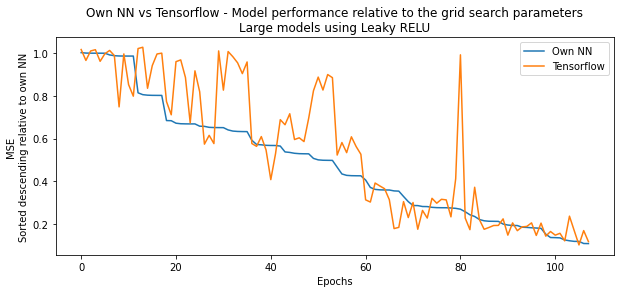

In [2]:
NN_vs_TF_file = f"{REPORT_DATA}NN_vs_TF_large_leaky_relu.csv"
NN_vs_TF_results = pd.read_csv(NN_vs_TF_file)
x = np.arange(NN_vs_TF_results.shape[0])
y_nn = NN_vs_TF_results["MSE_own_NN"].to_numpy()
y_tf = NN_vs_TF_results["MSE_tensorflow"].to_numpy()

plt.figure(figsize=(10,4))
plt.plot(x,y_nn, label=f"Own NN")
plt.plot(x,y_tf, label=f"Tensorflow")
plt.legend()
plt.ylabel("MSE \nSorted descending relative to own NN")
plt.xlabel("Epochs")
plt.title("Own NN vs Tensorflow - Model performance relative to the grid search parameters\nLarge models using Leaky RELU")
plt.savefig(f"{REPORT_FIGURES}Own_NN_vs_Tensorflow_Leaky_RELU_Large_architecture.pdf")
plt.show()

